# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: November 26, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: <mark>ALEJANDRO NIETO ALARCON</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

<font color='blue'>The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

<font color='blue'>A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise 1: BaseNet in CIFAR100 (3 points)**

<font color='blue'>*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation.

<font color='blue'>**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

<font color='blue'>Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

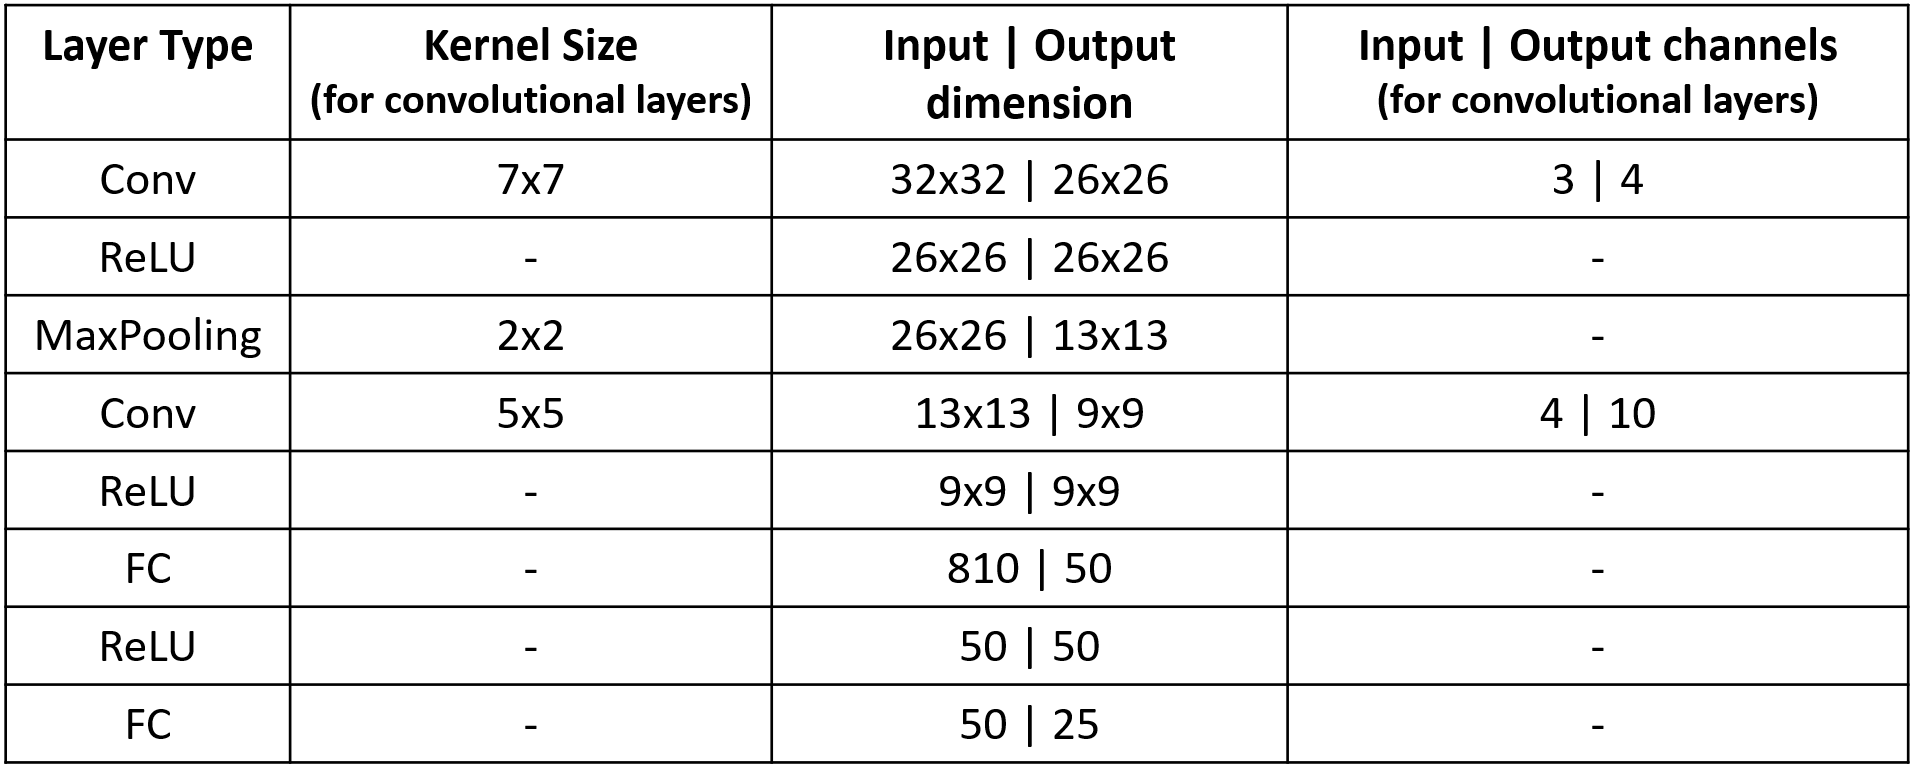


<font color='blue'>The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

<font color='blue'>Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/test'), Path('/root/.fastai/data/cifar100/train')]
[Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/medium_mammals'),


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/people ):  [Path('/root/.fastai/data/cifar100/train/people/girl'), Path('/root/.fastai/data/cifar100/train/people/man'), Path('/root/.fastai/data/cifar100/train/people/baby'), Path('/root/.fastai/data/cifar100/train/people/boy'), Path('/root/.fastai/data/cifar100/train/people/woman')]
Number of classes within superclass  0 :  5
Number of classes within superclass  1 :  5
Number of classes within superclass  2 :  5
Number of classes within superclass  3 :  5
Number of classes within superclass  4 :  5
Number of classes within superclass  5 :  5
Number of classes within superclass  6 :  5
Number of classes within superclass  7 :  5
Number of classes within superclass  8 :  5
Number of classes within superclass  9 :  5
Number of classes within superclass  10 :  5
Number of classes within superclass  11 :  5
Number of classes within superclass  12 :  5
Number of classes within superclass  13 :  5
Number of classes with

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

REMOVED SUPERCLASSES:
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/small_mammals
SUPERCLASSES WE KEEP:
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/large_omnivores_and_h

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/small_mammals


In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/people ):  [Path('/root/.fastai/data/cifar100/train/people/girl'), Path('/root/.fastai/data/cifar100/train/people/man'), Path('/root/.fastai/data/cifar100/train/people/baby'), Path('/root/.fastai/data/cifar100/train/people/boy'), Path('/root/.fastai/data/cifar100/train/people/woman')]
Total training images:  12500
Total test images:  2500


En primer lugar vamos a crear un datablock para cargar los datos dentro del modelo. Lo unico que tocaremos aqui es el items_tfms que ajustaremos a 32 pixeles ya que esa debe ser nuestra entrada (32x32 pixeles). También pondremos el path/'train' para que coja las imagenes puestas en la carpeta de train para entrenar y no las coja todas.

Una vez hecho lo anterior vamos a crear la estructura de red que se nos da en el ejercicio y crearemos el  objeto Learner.

In [ ]:
data_block = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                  get_y = parent_label,
                  item_tfms = [Resize(32, method = 'squish')]
                  ).dataloaders(path/'train', bs=32)


simple_net = sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size = (7,7)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size = (5,5)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features = 810, out_features = 50 ),
    nn.ReLU(),
    nn.Flatten() ,
    nn.Linear(in_features = 50, out_features = 25 ),

)

learn = Learner(data_block, simple_net, loss_func = CrossEntropyLossFlat(), metrics=accuracy)
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 4 x 26 x 26    
Conv2d                                    592        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 4 x 13 x 13    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 9 x 9     
Conv2d                                    1010       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 810            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

Pero antes de proseguir debemos ver que es lo que hace cada una de las capas que hemos puesto y por qué estan ahí:

1. Capa Convolucional:
La capa convolucional es responsable de aprender patrones locales en la entrada. Utiliza filtros (los kernels que hemos puesto) que se desplazan por la imagen para detectar características específicas, como bordes, texturas o patrones más complejos en capas más profundas.

2. Capa Max-Pooling:
Propósito: La capa de max-pooling reduce la dimensionalidad espacial de la entrada y disminuye la cantidad de parámetros y cálculos en la red.

3. Capa ReLU:
Propósito: La capa ReLU introduce no linealidades en la red y ayuda a la red a aprender representaciones más complejas. Introduce no linearidades al mantener valores positivos y establecer a cero los valores negativos.

4. Capa Flatten:
Propósito: La capa flatten transforma la salida de las capas anteriores en un vector unidimensional.

Ahora vamos a entrenar la red con el metodo fit_one_cycle durante 10 épocas y mostraremos los gráficos de las métricas.

epoch,train_loss,valid_loss,accuracy,time
0,3.016502,2.890822,0.150800,00:38
1,2.730646,2.690921,0.215600,00:21
2,2.595891,2.524264,0.245600,00:21
3,2.496930,2.512856,0.270000,00:23
4,2.340824,2.339137,0.309600,00:20
5,2.283647,2.289613,0.329200,00:21
6,2.228248,2.253065,0.331600,00:21
7,2.159060,2.234454,0.338800,00:22
8,2.143651,2.221764,0.346800,00:20
9,2.100180,2.215288,0.346400,00:22


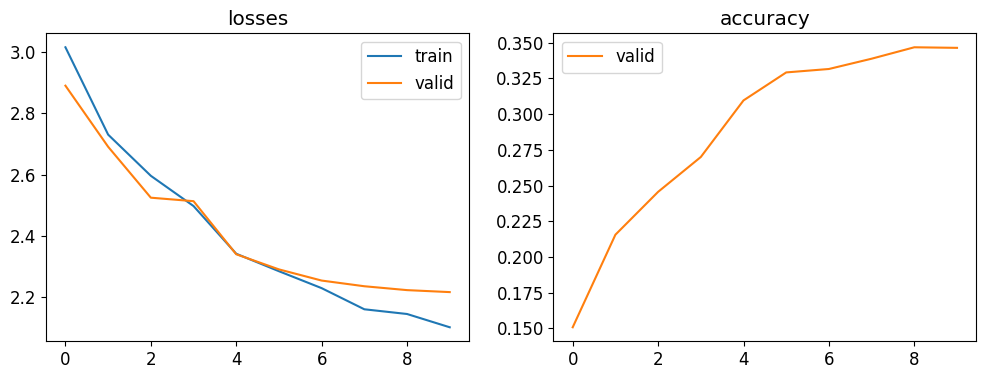

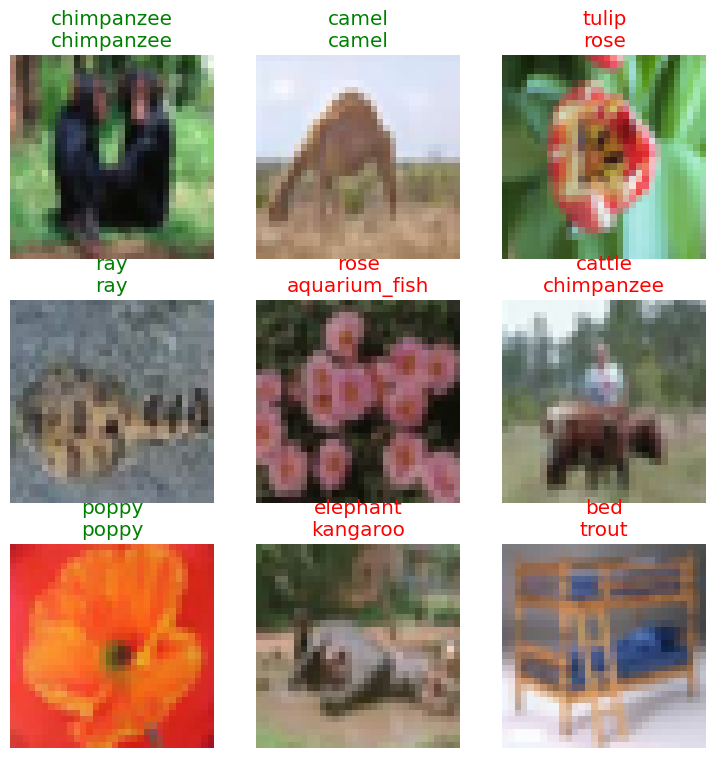

In [ ]:
learn.fit_one_cycle(10)
learn.recorder.plot_metrics()
learn.show_results()

Como podemos ver el ejemplo que se nos da es una red bastante simple y que tiene un desempeño muy malo durante las todas las epocas excepto en las finales en las cuales tiene un valor muy malo siendo dandonos a entender que la red es incapaz de generalizar.

Number of test examples: 2500


Test Accuracy
33.56


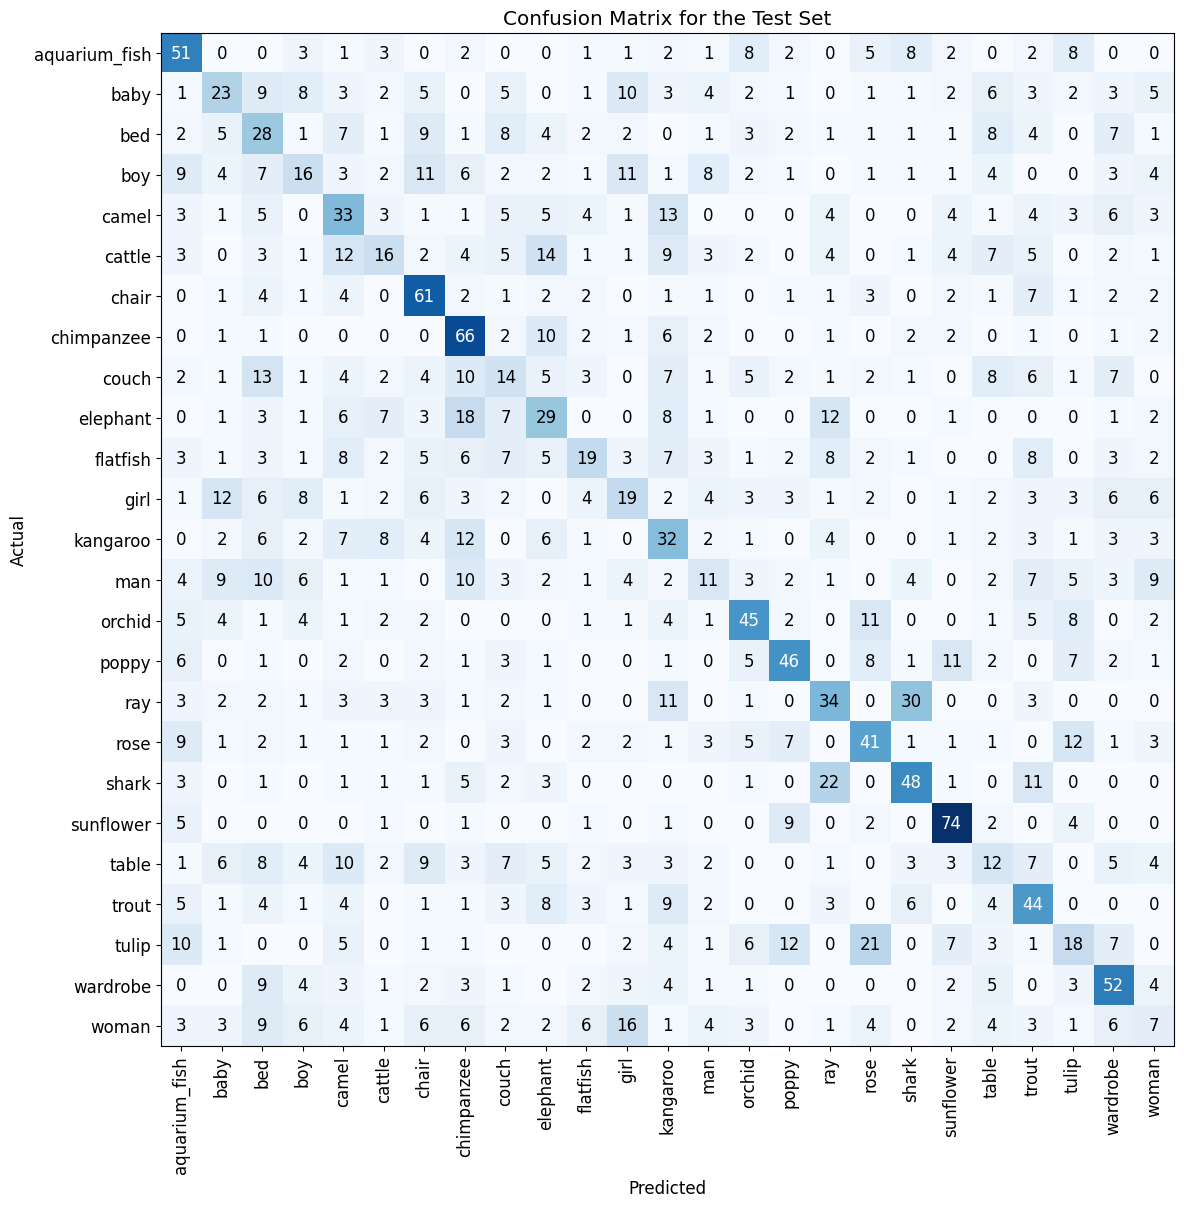

In [ ]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)
interp = ClassificationInterpretation.from_learner(learn, 5, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Aun asi obtener un valor de acuraccy malo pero que es mejor de lo que esperaba ya que la red al ser simple no deberia ser capaz de capturar muchos datos de las imagenes.

<font color='blue'>What is the total number of parameters of the created model? Break down the account made to reach that figure.



El número total de parametros de la red es:

In [ ]:
total_params(simple_net)[0]

43427

<font color='blue'>When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

En fastai, cuando se aborda un problema de clasificación multiclase, no es necesario incorporar explícitamente una función Softmax como última capa del modelo. La razón de esto es que la función de pérdida utilizada para problemas de clasificación multiclase generalmente incluye una activación softmax internamente.

La libreria fastai proporciona funciones de alto nivel que manejan automáticamente los componentes necesarios para la clasificación multiclase, incluida la activación de softmax. Específicamente, la clase Learner en Fastai selecciona automáticamente una función de pérdida apropiada según la tarea y, para la clasificación multiclase, generalmente usa la pérdida de entropía cruzada, que incorpora la activación softmax.



---



---



---



# <font color='blue'> **Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
<font color='blue'>Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

<font color='blue'>It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature).

<font color='blue'>A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataLoader or ImageDataLoaders class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that test_transform uses the same normalization parameters as train_transform.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataLoader or ImageDataLoaders class data zoom parameters, like zoom_range and/or horizontal_flip. Remember that you should not have any data augmentation in the validation or test sets. If you need a better understanding, try reading fastai's tutorial on transformations. Look at data augmentation using image transformations.

<font color='blue'> Feel free to incorporate modifications not included in the aforementioned list.

En esta parte vamos a coger el mismo bloque para cargar los datos que el anterior pero vamos a usar un item_tfms diferente vamos a usar el que se nos da en la guía de ayuda eso si haciendo resize de igual forma a 32 píxeles.
También vamos a añadir nuevas mejoras que tienen que ver con Data augmentation y Data normalization esto lo hacemos al incluir la nueva variable batch_tfms, dentro de esta variable pondremos la normalizacion y la augmentation. Data augmentation lo usamos con el objetivo de crear nuevas muestras de entrenamiento a partir de las muestras originales mediante la aplicación de transformaciones aleatorias ya que ayuda al modelo a generalizar mejor, ya que ve variaciones de los datos de entrenamiento y se vuelve más robusto a las variaciones en los datos de prueba. Lo que conseguimos tras usar normalización es ajustar las características del conjunto de datos para que tengan una escala común. El objetivo principal de la normalización es llevar todas las características a un rango comparable y centrarlas alrededor de cero, lo que puede mejorar el rendimiento y la convergencia de los modelos de aprendizaje automático.

También en el datablock tenemos que tener en cuenta que usaremos un batch size de 16 en lugar de 32 como usábamos en el primer apartado para ayudar a que el modelo generalice mejor ya que ve actualizaciones más frecuentes de los parámetros basadas en muestras diferentes.

Después de haber comentado esto comentaremos la red creada y es que uso una estructura en la que uso 3 capas convolucionales con el mismo kernel 3x3, esto equivale a un kernel de tamaño 7 pero el problema del kernel de tamaño 7 es que no extrae tantas caracteristicas de como lo haría si lo dividimos en capas de kenel 3x3 de esta forma somos capaces de extraer más carácterísticas y hacer nuestra red más robusta ya que introducimos mas no linearidad. También intente añadir capas de Dropout (son capas que desactivan ciertas neuronas de forma aleatoria para que la red generalice mejor) pero sin mucho éxito por lo cual decidí quitarlas.

Otra de las mejoras es el uso de early stopping tras 3 epocas en las que no mejora, de esta forma podemos dejar de entrenar a nuestro modelo antes de que empiece a sobreajustarse y conseguir una buena generalización.

epoch,train_loss,valid_loss,accuracy,time
0,2.690222,2.642769,0.217200,00:34
1,2.389665,2.234001,0.332800,00:31
2,2.236249,2.127990,0.344000,00:32
3,2.076032,1.947767,0.402400,00:31
4,1.970026,1.833378,0.437200,00:31
5,1.828837,1.733989,0.470000,00:31
6,1.714367,1.688264,0.466000,00:31
7,1.676996,1.627643,0.496000,00:31
8,1.567916,1.604222,0.502800,00:31
9,1.587773,1.601143,0.506800,00:32


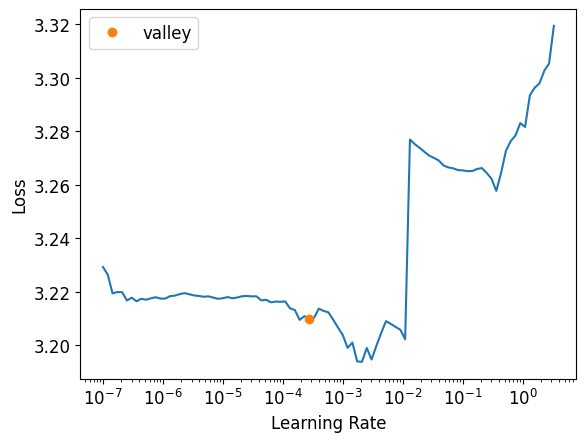

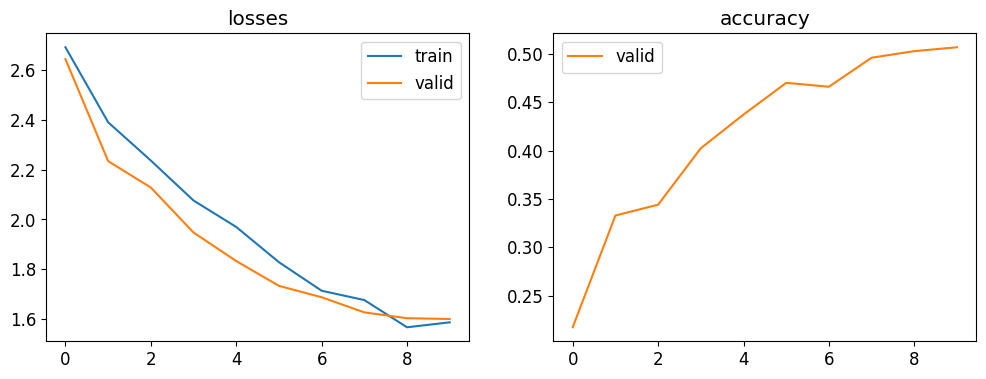

Sequential (Input shape: 16 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 30 x 30   
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 32 x 15 x 15   
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 64 x 13 x 13   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     16 x 128 x 11 x 11  
Conv2d                                    73856      True      
ReLU                                                           
______________________________________________

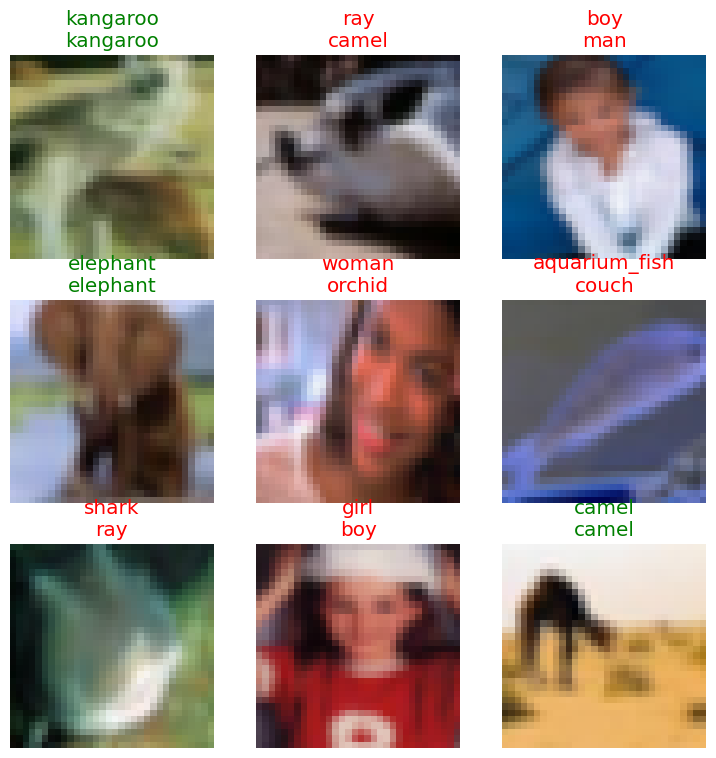

In [ ]:
data_block = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                  get_y = parent_label,
                  item_tfms=RandomResizedCrop(32, min_scale=0.5),
                  batch_tfms=[*aug_transforms(), Normalize.from_stats(*cifar_stats)]
                  ).dataloaders(path/'train', bs=16)

net_2 = sequential(
    nn.Conv2d(3, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(15488, 512),
    nn.ReLU(),
    nn.Linear(512, 25)
)


# Para Early Stopping
cbs=[SaveModelCallback(), ShowGraphCallback(),EarlyStoppingCallback(min_delta=0.01, patience=3)]

learn = Learner(data_block, net_2, loss_func = CrossEntropyLossFlat(), metrics=accuracy)
lr_seq = learn.lr_find()
learn.fit_one_cycle(10, lr_max = lr_seq[0] )

learn.recorder.plot_metrics()
learn.show_results()
learn.summary()

Como podemos ver esta red bastante aunque es bastante simple pero algo mas compleja que la anterior tiene un desempeño muy malo durante las todas las epocas excepto en las finales al igual que la anterior en las cuales tiene un valor muy malo siendo dandonos a entender que la red es incapaz de generalizar. Aun así con esta red somos capaces de obtener más detalles y obtener un mejor accuracy. Podriamos darle más etapas para ver como evoluciona e incluso podriamos darle de entrada más píxeles para ver como aprende eso si quizá si añadimos más píxeles necesitemos de más profundidad en la red para extraer las características de una mejor forma.

Number of test examples: 2500


Test Accuracy
49.559999999999995


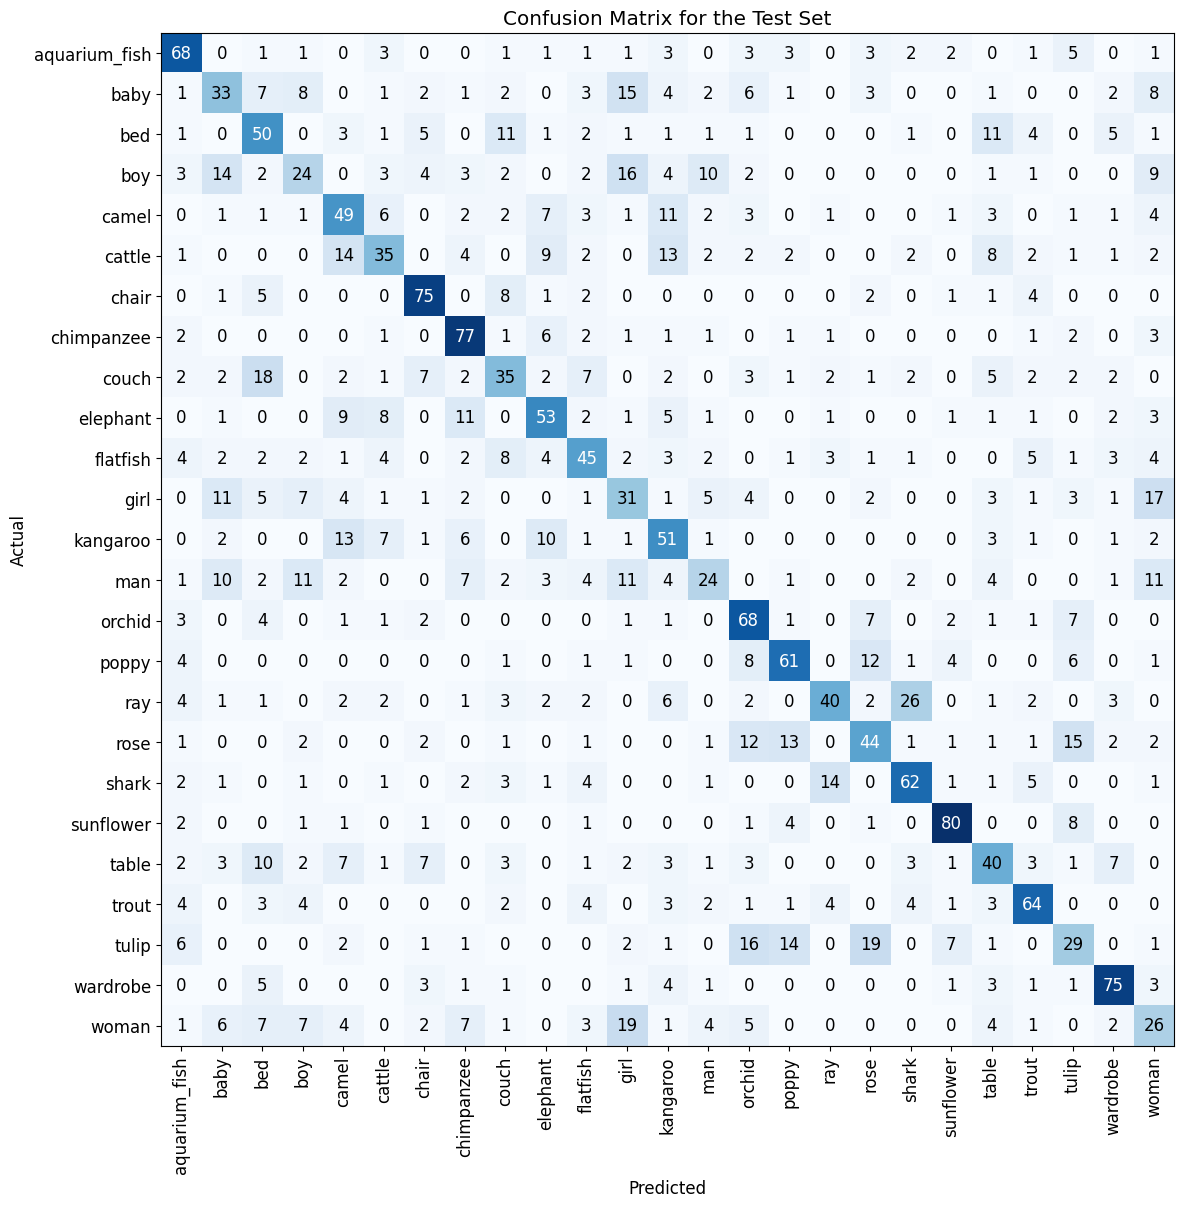

In [ ]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)
interp = ClassificationInterpretation.from_learner(learn, 5, test_dl)
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

Como podemos ver somos capaces de obtener mejores resultados que con la red de la parte 1 con las mejoras implementadas siendo capaces de capturar de esta forma mas características y haciendo el modelo más robusto.